In [36]:
# import libraries

import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import InputLayer,Conv2D, Dense, MaxPooling2D, Flatten, BatchNormalization, Dropout, GlobalAveragePooling2D
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
# create a function to load the data

MAIN_PATH = "HAM10000/"
IMAGE_PATH_1 = MAIN_PATH + "HAM10000_images_part_1/"
IMAGE_PATH_2 = MAIN_PATH + "HAM10000_images_part_2/"
LABEL_PATH = MAIN_PATH + 'HAM10000_metadata.csv'

In [3]:
# Read CSV data and sort by image_id

skin_df = pd.read_csv(LABEL_PATH).sort_values(by=["image_id"])
skin_df.head(7)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
4349,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk,vidir_molemax
4263,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity,vidir_molemax
4217,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk,vidir_molemax
3587,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk,vidir_molemax
1451,HAM_0003350,ISIC_0024310,mel,histo,60.0,male,chest,vidir_modern
4497,HAM_0000981,ISIC_0024311,nv,follow_up,75.0,female,back,vidir_molemax
700,HAM_0001359,ISIC_0024312,bkl,histo,75.0,male,lower extremity,rosendahl


In [4]:
# Display the different kind of DX

NUM_CLASSES = skin_df["dx"].nunique()

print(f"Number of Categories: {NUM_CLASSES}")

Number of Categories: 7


In [5]:
# Display the different kind of DX

dx_count = skin_df["dx"].unique()
print(f"Categories Names: {dx_count}")


Categories Names: ['nv' 'mel' 'bkl' 'df' 'akiec' 'bcc' 'vasc']


In [6]:
# Get the value counts of each DX

v_counts = skin_df["dx"].value_counts()
print (v_counts)

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


In [7]:
 # Plot the equilibre of the dataset

def plot_equilibre(labels, counts):

    plt.figure(figsize=(12, 8))

    sns_bar = sns.barplot(x=labels, y=counts)
    sns_bar.set_xticklabels(labels, rotation=45)
    plt.title('Equilibre of the New Dataset')
    plt.show()

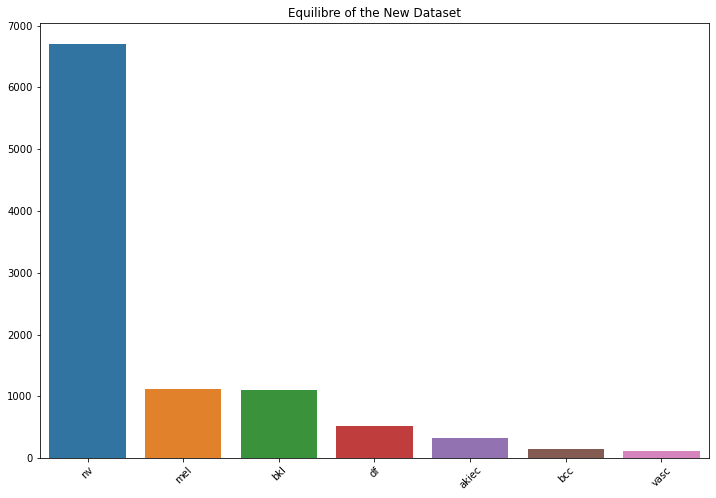

In [8]:
# Plot the equilibre of the dataset

plot_equilibre(dx_count, v_counts.to_numpy())

In [9]:
# Create a pie chart

def plot_pie(labels, counts):
    
        plt.figure(figsize=(12, 8))
        plt.title('Equilibre of the New Dataset')
        plt.pie(counts, labels=labels, 
                autopct='%1.1f%%', 
                shadow=True, 
                startangle=90,
                explode=[0.05, 0.05, 0.05, 0.05, 0.05, 0.05,0.05])

        plt.show()   

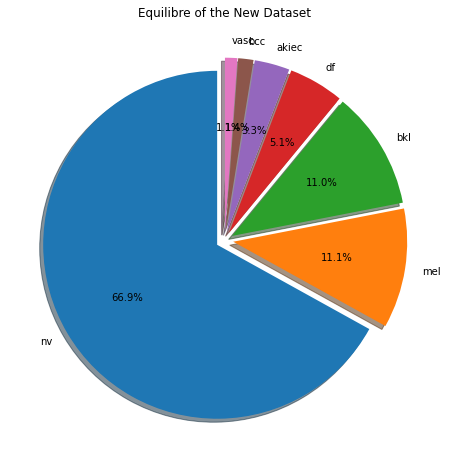

In [10]:
# Plot the pie chart

plot_pie(dx_count, v_counts.to_numpy())

In [11]:
# Get the image path for each image

def get_all_imgs(directory):
    """
    Function to gather all images' paths.  
    """
    img_paths = []
    tmp_img_list = os.listdir(directory)
    for tmp_path in tmp_img_list:
        img_path = os.path.join(directory, tmp_path)
        img_paths.append(img_path)
    img_paths.sort()
    
    return img_paths

# load the images

def load_process_img(file_name, size=(256, 256)):
    """
    Read and load an image from a file name.
    """
    img = tf.image.decode_jpeg(tf.io.read_file(file_name), channels=3)
    img = tf.image.resize(img, [size[0], size[1]], 'bicubic')
    img = tf.cast(img, tf.float32)

    return img

def create_dataset(img_paths, labels, img_size=(256, 256), batch_size=16, seed=23):
    """
    Create a dataset of images and labels.
    """
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, labels))
    dataset = dataset.shuffle(buffer_size=len(img_paths), reshuffle_each_iteration=False, seed=seed)
    dataset = dataset.map(lambda x, y: (load_process_img(x, img_size), y))
    dataset = dataset.batch(batch_size)
    print(f"Dataset has been created with {len(img_paths)} images grouped into batchs of {batch_size}.")
    return dataset

In [12]:
BATCH_SIZE = 16

# load all images

all_imgs_paths = get_all_imgs(IMAGE_PATH_1)
all_imgs_paths.extend(get_all_imgs(IMAGE_PATH_2))
print(f"Images Count: {len(all_imgs_paths)}")

# Encode the labels.

le = LabelEncoder()
encoded_labels = le.fit_transform(skin_df["dx"].to_numpy())

full_dataset = create_dataset(all_imgs_paths, encoded_labels, img_size=(256, 256), batch_size=BATCH_SIZE)

Images Count: 10015
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-05-02 16:52:32.706957: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Dataset has been created with 10015 images grouped into batchs of 16.


In [13]:
# Function to plot metrics of the model.

def plot_metric(m_history, metric: str, val=True):
  """
  Function to Plots the model metrics.
  """
  train_metric = m_history.history[metric]
  if val:
    val_metric = m_history.history["val_"+metric]

  num_epochs = range(1, len(train_metric)+1)
  plt.plot(num_epochs, train_metric)
  if val:
    plt.plot(num_epochs, val_metric)
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  if val:
    plt.title(f"Train and Validation: {metric}")
    plt.legend(["Train", "Validation"], loc="best")
  else:
    plt.title(f"Train : {metric}")
    plt.legend(["Train"], loc="best")
  
  plt.show()

DATA PRE-PROCESSING

DATA AUGMENTATION


In [14]:
# Data augmentation
# Function to augment the dataset.

def normalize_dataset(dataset, normalisation_range="01"):
    """
    Function to normalize the dataset.
    """
    if normalisation_range == "01":
        norm_layer = layers.Rescaling(1./255)
    elif normalisation_range == "-11":
        norm_layer = layers.Rescaling(1./127.5, offset= -1)
    else:
        raise ValueError("normalisation_range can only be 01 or -11")
    normalisation = Sequential([norm_layer])
    normalised_dataset = dataset.map(
        lambda x, y: (normalisation(x,training = True), y)
    )
    return normalised_dataset

def normalise_augment_dataset(dataset, normalise=True, normalisation_range="01", input_shape=(256, 256, 3)):
    """
    Function to augment the dataset.
    """
    if normalise:
        if normalisation_range == "01":
            normalisation_layer = layers.Rescaling(1./255)
        elif normalisation_range == "-11":
            normalisation_layer = layers.Rescaling(1./127.5, offset= -1)
        else:
            raise ValueError("normalisation_range can only be 01 or -11")
        data_augmentation = Sequential(
            [
                layers.RandomFlip("horizontal_and_vertical", input_shape=input_shape),
                layers.RandomRotation(0.9),
                layers.RandomBrightness([-0.4,0.4]),
                layers.RandomContrast(0.2),
                layers.RandomZoom(0.2),
                normalisation_layer,
            ]
        )
    else:
        data_augmentation = Sequential(
            [
                layers.RandomFlip("horizontal_and_vertical", input_shape=input_shape),
                layers.RandomRotation(0.9),
                layers.RandomBrightness([-0.4,0.4]),
                layers.RandomContrast(0.2),
                layers.RandomZoom(0.2),
            ]
        )
    augmented_dataset = dataset.map(
        lambda x, y: (data_augmentation(x, training=True), y)
    )
    return augmented_dataset
    

Splitting the data into training and test data

In [15]:
def split_dataset(dataset, train_val_prct=0.8, val_prct=0.2):
    """
    Function to split the dataset into train, validation and test.

    ## Parameters:
    - dataset: The dataset to split.
    - train_val_prct: The percentage of the dataset to use for training and validation.
    - val_prct: The percentage of the train_val_prct to use for validation.
    """
    dataset_size = dataset.cardinality().numpy()
    print(f"Dataset size: {dataset_size}")

    # The images that will be used for training and validation.
    # they represent "train_val_prct" (default 80%) of the original dataset.
    train_valid_split = int(dataset_size * train_val_prct)
    
    # The image dataset that will be used for training.
    # They represent 80% of the train_valid_split.
    train_split = int(train_valid_split * (1-val_prct))
    print(f"Train split batches: {train_split}")
    train_dataset = dataset.take(train_split)
    
    # The image dataset that will be used for validation.
    # They represent 20% of the train_valid_split.
    valid_split = train_valid_split - train_split
    print(f"Validation split batches: {valid_split}")
    val_dataset = dataset.skip(train_split).take(valid_split)

    # The image dataset that will be used for testing.
    # They represent 20% of the original dataset.
    test_split = dataset_size - train_valid_split
    print(f"Test split batches: {test_split}")
    test_dataset = dataset.skip(train_valid_split)

    return train_dataset, val_dataset, test_dataset


In [16]:
train_dataset, valid_dataset, test_dataset = split_dataset(full_dataset, train_val_prct=0.8, val_prct=0.2)

Dataset size: 626
Train split batches: 400
Validation split batches: 100
Test split batches: 126


In [17]:
print(train_dataset.cardinality())
print(valid_dataset.cardinality())
print(test_dataset.cardinality())


tf.Tensor(400, shape=(), dtype=int64)
tf.Tensor(100, shape=(), dtype=int64)
tf.Tensor(126, shape=(), dtype=int64)


In [18]:
# plot the percentage of each dataset

def plot_percentage(train, valid, test):
        
        plt.figure(figsize=(12, 8))
        plt.title('Percentage of each dataset')
        plt.pie([train, valid, test], labels=["Train", "Valid", "Test"], 
                autopct='%1.2f%%', 
                shadow=True, 
                startangle=90,
                explode=[0.05, 0.05, 0.05])
        plt.show()

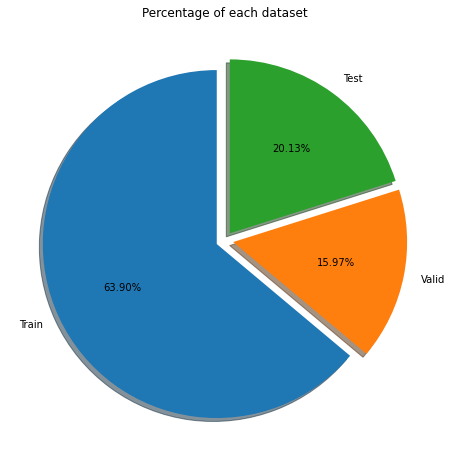

In [19]:
# Plot the percentage of each dataset

plot_percentage(train_dataset.cardinality(), valid_dataset.cardinality(), test_dataset.cardinality())

IMG Batch: 
(TensorShape([16, 256, 256, 3]), tf.float32)
Label Batch: 
(TensorShape([16]), tf.int64)


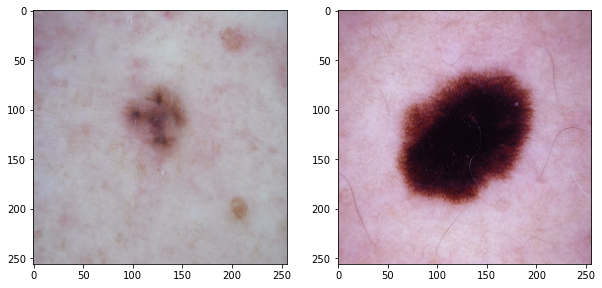

In [20]:
# Example of the produced datasets.

for img_batch in train_dataset.take(1):

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(tf.cast(img_batch[0][0], tf.uint8));
    plt.subplot(1, 2, 2)
    plt.imshow(tf.cast(img_batch[0][1], tf.uint8))
    
    print(f"IMG Batch: \n{img_batch[0].shape, img_batch[0].dtype}")
    print(f"Label Batch: \n{img_batch[1].shape, img_batch[1].dtype}")

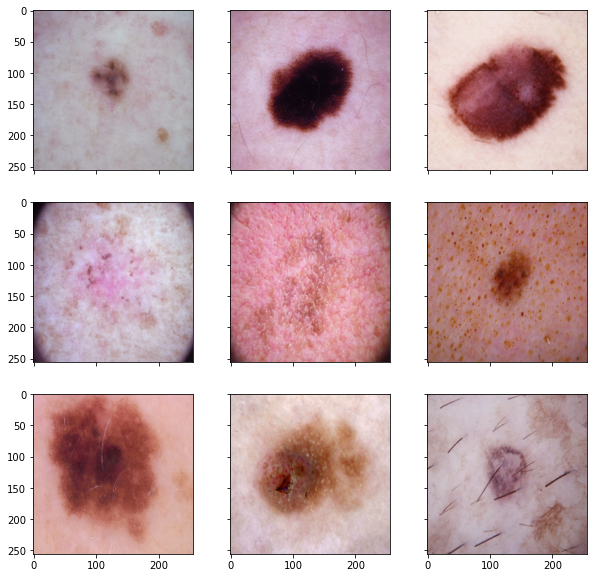

In [21]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10,10))
 
for images, labels in train_dataset.take(1):
    for i in range(3):
        for j in range(3):
            ax[i][j].imshow(images[i*3+j].numpy().astype("uint8"))
            
plt.show()

In [22]:
# change the normalisation_range to 01

train_dataset = normalise_augment_dataset(train_dataset, normalisation_range="01", input_shape=(256, 256, 3))
valid_dataset = normalise_augment_dataset(valid_dataset, normalisation_range="01", input_shape=(256, 256, 3))
test_dataset  = normalize_dataset(test_dataset, normalisation_range="01")

In [23]:
# prefetch the data
# Optimize the data loading with prefetching

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset  = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

TRAINING MODEL

CNN MODEL

In [47]:
EPOCHS = 30

# callbacks
my_callbacks = EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True)

In [48]:
# CNN Model 

model = Sequential([

    InputLayer(input_shape=(256, 256, 3)),
    Conv2D(filters = 8, kernel_size = (3,3), padding = "same", 
           kernel_regularizer = tf.keras.regularizers.L2(0.01), activation = tf.nn.relu),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),

    Conv2D(filters = 16, kernel_size = (3,3), padding = "same", 
           kernel_regularizer = tf.keras.regularizers.L2(0.01), activation = tf.nn.relu),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),

    Conv2D(filters = 32, kernel_size = (3,3), padding = "same", 
           kernel_regularizer = tf.keras.regularizers.L2(0.01), activation = tf.nn.relu),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),

    Conv2D(filters = 64, kernel_size = (3,3), padding = "same", 
           kernel_regularizer = tf.keras.regularizers.L2(0.01), activation = tf.nn.relu),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),

    Conv2D(filters = 128, kernel_size = (3,3), padding = "same", 
           kernel_regularizer = tf.keras.regularizers.L2(0.01), activation = tf.nn.relu),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),

    Flatten(),
    Dense(256, kernel_regularizer = tf.keras.regularizers.L2(0.01), activation="relu"),
    Dropout(0.25),
    Dense(128, kernel_regularizer = tf.keras.regularizers.L2(0.01), activation="relu"),
    Dropout(0.1),
    Dense(64, activation="relu"),
    Dense(NUM_CLASSES, activation = "softmax"),
])

In [49]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = "sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [50]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 8)      32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      1168      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 16)     64        
 hNormalization)                                                 
                                                      

In [71]:
# Train the model

history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=valid_dataset,
                    callbacks=[my_callbacks])

Epoch 1/30


2023-05-01 23:06:53.359658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


400/400 [==============================] - ETA: 0s - loss: 5.2246 - accuracy: 0.6333

2023-05-01 23:07:10.778966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


400/400 [==============================] - 22s 46ms/step - loss: 5.2246 - accuracy: 0.6333 - val_loss: 2.6692 - val_accuracy: 0.6144
Epoch 2/30
400/400 [==============================] - 16s 41ms/step - loss: 2.0266 - accuracy: 0.6669 - val_loss: 1.6734 - val_accuracy: 0.6644
Epoch 3/30
400/400 [==============================] - 16s 39ms/step - loss: 1.5224 - accuracy: 0.6698 - val_loss: 1.3925 - val_accuracy: 0.6731
Epoch 4/30
400/400 [==============================] - 16s 41ms/step - loss: 1.3179 - accuracy: 0.6692 - val_loss: 1.2828 - val_accuracy: 0.6394
Epoch 5/30
400/400 [==============================] - 16s 40ms/step - loss: 1.2056 - accuracy: 0.6727 - val_loss: 1.1820 - val_accuracy: 0.6719
Epoch 6/30
400/400 [==============================] - 16s 40ms/step - loss: 1.1740 - accuracy: 0.6716 - val_loss: 1.1611 - val_accuracy: 0.6237
Epoch 7/30
400/400 [==============================] - 16s 40ms/step - loss: 1.1294 - accuracy: 0.6737 - val_loss: 1.2468 - val_accuracy: 0.6706
Epo

In [72]:
# save the model

model.save("Models/model_1.h5")

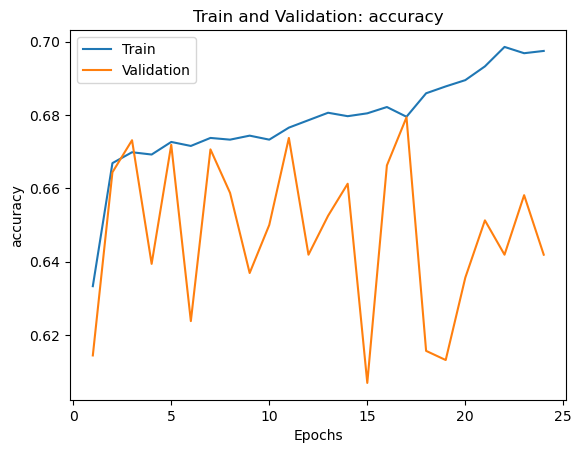

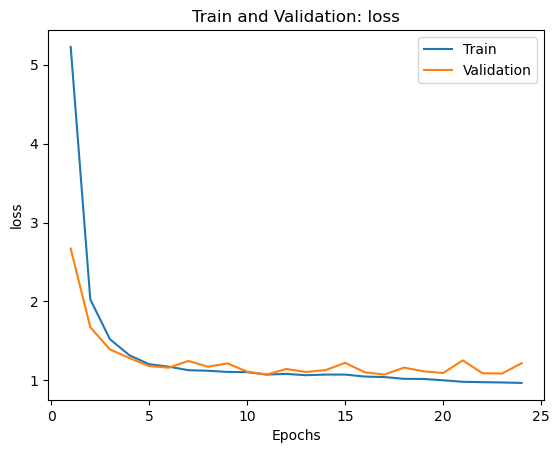

In [73]:
# Plot accuracy
plot_metric(history, "accuracy")

# Plotting Losses.
plot_metric(history, "loss")

In [74]:
# Evaluate the model

model.evaluate(test_dataset)

126/126 [==============================] - 7s 55ms/step - loss: 1.0789 - accuracy: 0.6680


[1.078874111175537, 0.6679900884628296]

In [51]:
# Load the model

model_trained = load_model("Models/model_1.h5")

In [52]:
# Predictions

# Predictions on the test dataset.

test_predictions_labels = model_trained.predict(test_dataset).argmax(axis=1)

126/126 [==============================] - 34s 144ms/step


In [53]:
# true labels

test_true_labels = np.concatenate([y for x, y in test_dataset], axis=0)

In [55]:
# Plot the confusion matrix

cm = confusion_matrix(test_true_labels, test_predictions_labels)   

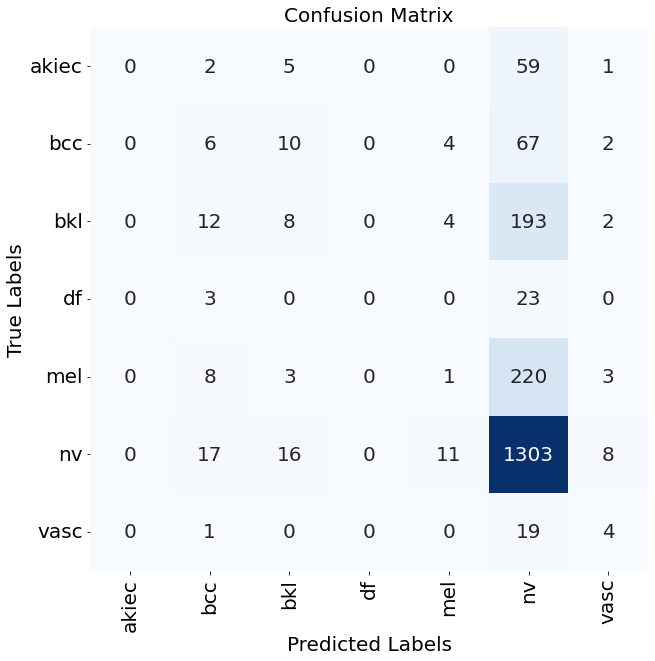

In [56]:
# Plot the confusion matrix

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 20})
plt.xticks(ticks=np.arange(NUM_CLASSES) + 0.5, labels=le.classes_, rotation=90, fontsize=20)
plt.yticks(ticks=np.arange(NUM_CLASSES) + 0.5, labels=le.classes_, rotation=0, fontsize=20)
plt.xlabel("Predicted Labels", fontsize=20)
plt.ylabel("True Labels", fontsize=20)
plt.title("Confusion Matrix", fontsize=20)
plt.show()

### Transfer Learning

#### EfficientNetV2B3  Model

In [24]:
pretrained_model = tf.keras.applications.EfficientNetV2B3(input_shape=(256, 256, 3), include_preprocessing=False, include_top=False, weights="imagenet")

pretrained_model.trainable = False

52606240/52606240 [==============================] - 7s 0us/step


In [25]:
transfer_model = Sequential([
    pretrained_model, 
    GlobalAveragePooling2D(),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation="softmax")
])

In [26]:
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = "sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [27]:
transfer_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Function  (None, 8, 8, 1536)       12930622  
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)              

##### Creating Train, Validation, and Test Datasets.

In [28]:
BATCH_SIZE = 16

# load all images

all_imgs_paths = get_all_imgs(IMAGE_PATH_1)
all_imgs_paths.extend(get_all_imgs(IMAGE_PATH_2))
print(f"Images Count: {len(all_imgs_paths)}")

# Encode the labels.

le = LabelEncoder()
encoded_labels = le.fit_transform(skin_df["dx"].to_numpy())

full_dataset = create_dataset(all_imgs_paths, encoded_labels, img_size=(256, 256), batch_size=BATCH_SIZE)

Images Count: 10015
Dataset has been created with 10015 images grouped into batchs of 16.


In [29]:
train_dataset, valid_dataset, test_dataset = split_dataset(full_dataset, train_val_prct=0.8, val_prct=0.2)

Dataset size: 626
Train split batches: 400
Validation split batches: 100
Test split batches: 126


In [30]:
train_dataset = normalise_augment_dataset(train_dataset, normalise=True, normalisation_range="-11", input_shape=(256, 256, 3))
valid_dataset = normalise_augment_dataset(valid_dataset, normalise=True, normalisation_range="-11", input_shape=(256, 256, 3))
test_dataset  = normalize_dataset(test_dataset, normalisation_range="-11")

#### Training The Model

In [31]:
transfer_history = transfer_model.fit(train_dataset, validation_data=valid_dataset, epochs=15)

Epoch 1/15
400/400 [==============================] - 524s 1s/step - loss: 1.0142 - accuracy: 0.6648 - val_loss: 0.8444 - val_accuracy: 0.6844
Epoch 2/15
400/400 [==============================] - 580s 1s/step - loss: 0.9155 - accuracy: 0.6836 - val_loss: 0.7989 - val_accuracy: 0.7100
Epoch 3/15
400/400 [==============================] - 598s 1s/step - loss: 0.8596 - accuracy: 0.6975 - val_loss: 0.7656 - val_accuracy: 0.7244
Epoch 4/15
400/400 [==============================] - 598s 1s/step - loss: 0.8459 - accuracy: 0.6977 - val_loss: 0.7474 - val_accuracy: 0.7319
Epoch 5/15
400/400 [==============================] - 559s 1s/step - loss: 0.8285 - accuracy: 0.7064 - val_loss: 0.7511 - val_accuracy: 0.7375
Epoch 6/15
400/400 [==============================] - 560s 1s/step - loss: 0.8248 - accuracy: 0.7091 - val_loss: 0.7355 - val_accuracy: 0.7287
Epoch 7/15
400/400 [==============================] - 561s 1s/step - loss: 0.7919 - accuracy: 0.7177 - val_loss: 0.7309 - val_accuracy: 0.7350

In [32]:
transfer_model.save("Models/EfficientNetV2B3.h5")

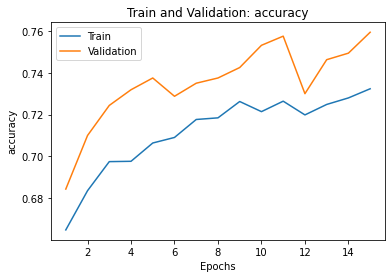

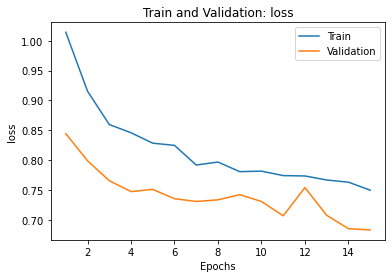

In [33]:
plot_metric(transfer_history, "accuracy")

plot_metric(transfer_history, "loss")

In [34]:
transfer_model.evaluate(test_dataset)

126/126 [==============================] - 142s 965ms/step - loss: 0.6995 - accuracy: 0.7444


[0.6994624137878418, 0.7444168925285339]

In [37]:
# Load the model

transfer_model_trained = load_model("Models/EfficientNetV2B3.h5")

In [40]:
# Predictions

# Predictions on the test dataset.

test_predictions_labels = transfer_model_trained.predict(test_dataset).argmax(axis=1)

126/126 [==============================] - 130s 873ms/step


In [42]:
# true labels

test_true_labels = np.concatenate([y for x, y in test_dataset], axis=0)

In [44]:
# Plot the confusion matrix

cm = confusion_matrix(test_true_labels, test_predictions_labels)    

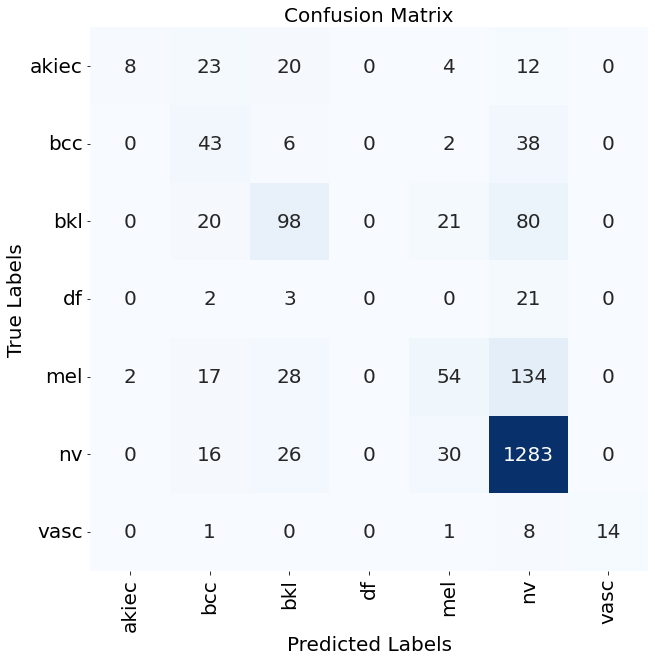

In [46]:
# Plot the confusion matrix

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 20})
plt.xticks(ticks=np.arange(NUM_CLASSES) + 0.5, labels=le.classes_, rotation=90, fontsize=20)
plt.yticks(ticks=np.arange(NUM_CLASSES) + 0.5, labels=le.classes_, rotation=0, fontsize=20)
plt.xlabel("Predicted Labels", fontsize=20)
plt.ylabel("True Labels", fontsize=20)
plt.title("Confusion Matrix", fontsize=20)
plt.show()